In [2]:
# from transformers import ViTFeatureExtractor, ViTForImageClassification, BatchFeature
import requests
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler as GradScaler
import time, datetime
import logging
from birealnet import *
# from mobilenetv3 import *
from mobilenetv3 import *
from utils import *
from blurpool import *
import pathlib
import dill
import re

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
import memtorch
import mock
import copy
from memtorch.mn.Module import patch_model
from memtorch.map.Input import naive_scale
from memtorch.map.Parameter import naive_map


In [5]:
def train(model, train_data_loader, optimizer, epoch, datasets, model_name, criterion=nn.CrossEntropyLoss(), logger_train = None,
          print_freq=10, scaler = None):
    
    print(model_name)
    
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    model.to(device)
    model.train()

    end = time.time()
    for i, (batch, label) in enumerate(train_data_loader):
        data_time.update(time.time() - end)

        batch = batch.to(device)
        label = label.to(device)

#         output = model(batch)
#         loss = criterion(output, label)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(batch)
            loss = criterion(output, label)
            
        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, label, topk=(1, 5))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        losses.update(loss.item(), batch.size(0))
        top1.update(acc1[0], batch.size(0))
        top5.update(acc5[0], batch.size(0))

#         loss.backward()
#         optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % print_freq == 0:
            progress.display(i)

            msg = ('Epoch: [{0}][{1}/{2}]\t'
                   'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                   'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                   'Prec@5 {top5.val:.3f} ({top5.avg:.3f})\t')
            logger_train.info(msg.format(epoch, i, len(train_data_loader),
                                         batch_time=batch_time,
                                         data_time=data_time,
                                         loss=losses,
                                         top1=top1,
                                         top5=top5))
    closer_logger(logger_train)

    return top1.avg, top5.avg

In [6]:
def test(model, test_data_loader, epoch, datasets, model_name, criterion=torch.nn.CrossEntropyLoss(), logger_test = None,
         print_freq=10):

    # logging.basicConfig(filename=model_name + "_test.log", level=logging.INFO, format='%(message)s')
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(test_data_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    model.to(device)
    model.eval()
    with torch.no_grad():
        end = time.time()
    for i, (batch, label) in enumerate(test_data_loader):
        batch = batch.to(device)
        label = label.to(device)

        output = model(batch)
        loss = criterion(output, label)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, label, topk=(1, 5))
        losses.update(loss.item(), batch.size(0))
        top1.update(acc1[0], batch.size(0))
        top5.update(acc5[0], batch.size(0))
        # measure elapsed time
        # batch_time.update(t1 - t0)
        batch_time.update(time.time() - end)
        end_time = time.time()

        if i % print_freq == 0:
            progress.display(i)

        msg = ('Epoch: [{0}][{1}/{2}]\t'
               'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
               'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
               'Prec@5 {top5.val:.3f} ({top5.avg:.3f})\t')
        logger_test.info(msg.format(epoch, i, len(test_data_loader),
                                    loss=losses,
                                    top1=top1,
                                    top5=top5))
    closer_logger(logger_test)
        
    print(' * acc@1 {top1.avg:.3f} acc@5 {top5.avg:.3f}'
        .format(top1=top1, top5=top5))
    return top1.avg, top5.avg, losses.avg

In [7]:
def fit(model, train_data_loader, test_data_loader, datasets, optimizer, lr_schedule=None, epochs=10,
        criterion1=torch.nn.CrossEntropyLoss(), criterion2 = torch.nn.CrossEntropyLoss(),
        print_freq=10, save_model=False, save_params=False, best_acc=0, model_name=None):
    start_t = time.time()
    # model = torch.nn.DataParallel(model)
    scaler = GradScaler()
    
    # create 3 logger for ploting
    file_complete = creating_path("pub","Ye","logs", model_name, datasets, "learning_rate",
                                  file_name="LR" + "_" + model_name, extension='log')
    logger_complete = create_logger("complete", file_complete)
    scheduler = lr_schedule
    
    train_file = creating_path("pub","Ye",'logs', model_name, datasets, 'train_logger', file_name="__" + model_name + 
                               "__run__" + "_training", extension='log')
    train_path_name = train_file
    logger_train = create_logger('train_file', train_file)
    
    test_file = creating_path("pub","Ye",'logs', model_name, datasets, 'test_logger', file_name="__" + model_name +
                              "__run__" + "_test", extension='log')
    test_path_name = test_file
    logger_test = create_logger('test', test_file)
    
    
    train_1_a = list([])
    test_1_a = list([])
    train_5_a = list([])
    test_5_a = list([])
    val_loss = 0
    for epoch in range(epochs):
        if lr_schedule is not None:
            for param_group in optimizer.param_groups:
                lr = param_group['lr']
            print("Epoch: ", epoch, "LR:", lr)
        else:
            lr = optimizer.__dict__['defaults']['lr']
            adjust_learning_rate(optimizer, epochs, lr)
            print("Epoch: ", epoch, "LR:", lr)

        train_accuracy1, train_accuracy5 = train(model, train_data_loader, optimizer, epoch, datasets,
                                                 model_name, criterion2, logger_train, print_freq, scaler)

        test_accuracy1, test_accuracy5, val_loss = test(model, test_data_loader, epoch, datasets, model_name, criterion1,
                                              logger_test, print_freq)
        
        train_1_a.append(train_accuracy1)
        train_5_a.append(train_accuracy5)
        test_1_a.append(test_accuracy1)
        test_5_a.append(test_accuracy5)
        
        if test_accuracy1 > best_acc:
            if save_model is True:
                print("=== The model is saved with accuracy: {}".format(test_accuracy1))
                model_save(model, test_accuracy1, model_name=model_name, datasets=datasets)
                best_acc = test_accuracy1
            if save_params is True:
                print("=== The model parameters is saved with accuracy: {}".format(test_accuracy1))
                params_save(model, epoch, optimizer, train_accuracy1,
                            test_accuracy1, model_name=model_name, datasets=datasets)
                best_acc = test_accuracy1

        cur_lr = optimizer.param_groups[0]['lr']

        msg = ('Epoch: [{0}]\t'
               'LR:[{1}]\t'
               'Cur_LR:[{2}]\t'
               'Train_acc@1 {acc1:3}\t'
               'Train_acc@5 {acc5:4}\t'
               'Test_acc@1 {acc1:3}\t'
               'Test_acc@5 {acc5:4}\t'
               )
        logger_complete.info(msg.format(epoch, lr, cur_lr,
                                        acc1=test_accuracy1, acc5=test_accuracy5))

        closer_logger(logger_complete)

        if lr_schedule is not None:
            scheduler.step(val_loss)
#             scheduler.step()
        else:
            continue

    t_m, t_s = divmod(time.time() - start_t, 60)
    t_h, t_m = divmod(t_m, 60)
    print("Finished training.")
    print('total training time is {:d}:{:02d}:{:02d}'.format(int(t_h), int(t_m), int(t_s)))

    return train_1_a, train_5_a, test_1_a, test_5_a, train_file, test_file


In [8]:
# hyper parameters
CLASSES = 10
batch_size = 128
max_epochs = 200
lr = 0.05
momentum = 0.9
weight_decay = 6e-5
label_smooth = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
datasets = 'CIFAR-10'
# model_name = 'Mobilenetv3_small_b_pre_memsist_test'
model_name = 'Birealnet_properly'

In [9]:
model = mobilenetv3_small(if_binary = True)
# model = birealnet18(num_classes = 10)
summary(model.to(device), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
             ReLU6-3           [-1, 16, 32, 32]               0
         h_sigmoid-4           [-1, 16, 32, 32]               0
           h_swish-5           [-1, 16, 32, 32]               0
  BinaryActivation-6           [-1, 16, 32, 32]               0
    HardBinaryConv-7           [-1, 16, 32, 32]               0
       BatchNorm2d-8           [-1, 16, 32, 32]              32
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                    [-1, 8]             136
             ReLU-11                    [-1, 8]               0
           Linear-12                   [-1, 16]             144
            ReLU6-13                   [-1, 16]               0
        h_sigmoid-14                   

In [ ]:
# data augmentation
# crop_scale = 0.08
# lighting_param = 0.1
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
# train_transforms = transforms.Compose([
#         transforms.RandomResizedCrop(32, scale=(crop_scale, 1.0)),
#         Lighting(lighting_param),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         normalize])

# val_transforms = transforms.Compose([
# #             transforms.Resize(256),
#             transforms.CenterCrop(32),
#             transforms.ToTensor(),
#             normalize
#         ])

In [ ]:
# train_loader = DataLoader( 
#     torchvision.datasets.CIFAR10('./', download=True, transform=train_transforms),
#     batch_size=batch_size,
#     shuffle=True
# #     num_workers=num_workers, pin_memory=True
# )
# test_loader = DataLoader( 
#     torchvision.datasets.CIFAR10('./', download=True, train=False, transform=val_transforms),
#     batch_size=batch_size,
#     shuffle=False
# #     num_workers=num_workers, pin_memory=True
# )

data_loader = Cifar10DataLoader(batch_size = batch_size)
train_loader = data_loader['train']
test_loader = data_loader['val']
train_loader_len = len(train_loader)
val_loader_len = len(test_loader)
loaders_len = {'train': train_loader_len, 'val' : val_loader_len}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
#                                               lambda step : (1.0-step/max_epochs), last_epoch=-1)
# scheduler = CosineWarmupLR(optimizer=optimizer_ft, epochs=max_epochs, 
#                               iter_in_one_epoch=loaders_len['train'], lr_min=0, warmup_epochs=5)
scheduler = ReduceLROnPlateau(optimizer, 'min')

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
criterion_smooth = CrossEntropyLabelSmooth(CLASSES, label_smooth)
criterion_smooth = criterion_smooth.to(device)
loaders_len = {'train': train_loader_len, 'val' : val_loader_len}

In [13]:
train_1_a, train_5_a, test_1_a, test_5_a, train_path_name, test_path_name = fit(model, train_loader, test_loader, datasets, optimizer, scheduler, max_epochs,
        criterion, criterion_smooth,
        print_freq=10, save_model=True, save_params=True, best_acc=0, model_name = model_name)

Epoch:  0 LR: 0.05
Birealnet_properly
Epoch: [0][  0/391]	Time  1.166 ( 1.166)	Data  1.035 ( 1.035)	Loss 2.7147e+00 (2.7147e+00)	Acc@1   5.47 (  5.47)	Acc@5  50.78 ( 50.78)
Epoch: [0][ 10/391]	Time  0.029 ( 0.134)	Data  0.000 ( 0.094)	Loss 6.7906e+01 (5.3817e+01)	Acc@1  10.16 (  9.94)	Acc@5  56.25 ( 52.13)
Epoch: [0][ 20/391]	Time  0.029 ( 0.085)	Data  0.000 ( 0.049)	Loss 5.7671e+01 (5.6348e+01)	Acc@1  13.28 ( 11.76)	Acc@5  51.56 ( 55.99)
Epoch: [0][ 30/391]	Time  0.032 ( 0.067)	Data  0.000 ( 0.033)	Loss 4.9077e+01 (5.4815e+01)	Acc@1  14.84 ( 11.69)	Acc@5  44.53 ( 53.65)
Epoch: [0][ 40/391]	Time  0.033 ( 0.058)	Data  0.000 ( 0.025)	Loss 1.7833e+01 (4.7985e+01)	Acc@1  18.75 ( 11.59)	Acc@5  63.28 ( 53.62)
Epoch: [0][ 50/391]	Time  0.037 ( 0.053)	Data  0.000 ( 0.020)	Loss 6.5282e+00 (4.0488e+01)	Acc@1  17.19 ( 11.93)	Acc@5  58.59 ( 53.75)
Epoch: [0][ 60/391]	Time  0.033 ( 0.050)	Data  0.000 ( 0.017)	Loss 3.7357e+00 (3.4617e+01)	Acc@1  13.28 ( 11.53)	Acc@5  67.19 ( 54.39)
Epoch: [0][ 70/39

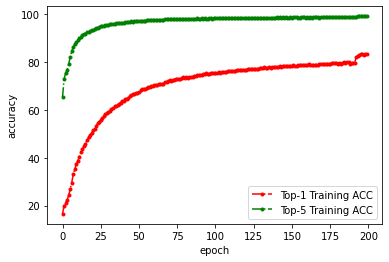

best training result: 83.465996 at epoch 200


In [14]:
# figure
plt.plot(train_1_a,'r.-.', label = "Top-1 Training ACC")
plt.plot(train_5_a,'g.-.', label = "Top-5 Training ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best training result: %f at epoch %d'% (np.amax(train_1_a), np.argmax(train_1_a)+1))

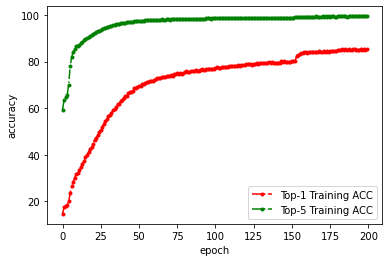

best training result: 85.372002 at epoch 191


In [ ]:
# figure
plt.plot(train_1_a,'r.-.', label = "Top-1 Training ACC")
plt.plot(train_5_a,'g.-.', label = "Top-5 Training ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best training result: %f at epoch %d'% (np.amax(train_1_a), np.argmax(train_1_a)+1))

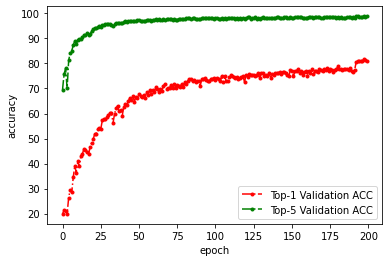

best validation result: 81.589996 at epoch 198


In [15]:
# figure
plt.plot(test_1_a,'r.-.', label = "Top-1 Validation ACC")
plt.plot(test_5_a,'g.-.', label = "Top-5 Validation ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best validation result: %f at epoch %d'% (np.amax(test_1_a), np.argmax(test_1_a)+1))

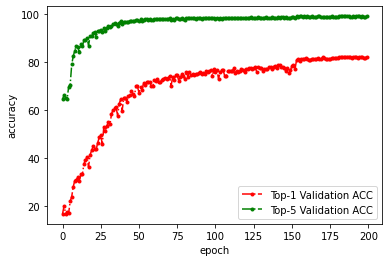

best validation result: 82.209999 at epoch 192


In [ ]:
# figure
plt.plot(test_1_a,'r.-.', label = "Top-1 Validation ACC")
plt.plot(test_5_a,'g.-.', label = "Top-5 Validation ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best validation result: %f at epoch %d'% (np.amax(test_1_a), np.argmax(test_1_a)+1))

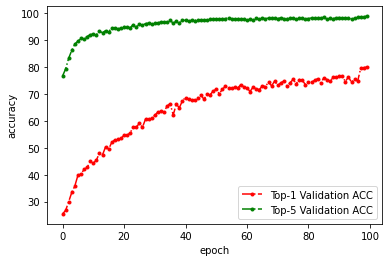

best validation result: 79.970001 at epoch 100


In [ ]:
# figure
plt.plot(test_1_a,'r.-.', label = "Top-1 Validation ACC")
plt.plot(test_5_a,'g.-.', label = "Top-5 Validation ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best validation result: %f at epoch %d'% (np.amax(test_1_a), np.argmax(test_1_a)+1))

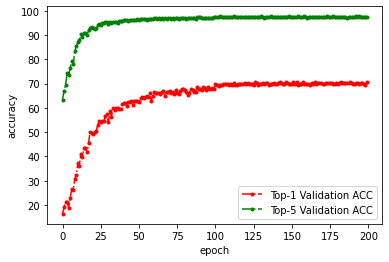

In [ ]:
# figure
plt.plot(test_1_a,'r.-.', label = "Top-1 Validation ACC")
plt.plot(test_5_a,'g.-.', label = "Top-5 Validation ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best validation result: %f at epoch %d'% (np.amax(test_1_a), np.argmax(test_1_a)+1))

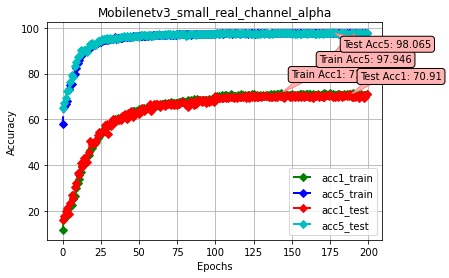

In [ ]:
pretty_plot(model_name, datasets)

In [ ]:
print(train_path_name)

NameError: name 'train_path_name' is not defined

In [ ]:
PATH = 'pub\Ye\Resutls\Mobilenetv3_small_real_channel_alpha_.pth.tar'
checkpoint = torch.load(PATH)

In [ ]:
print(checkpoint)

{'epoch': 153, 'model_state_dict': OrderedDict([('features.0.0.weight', tensor([[[[-0.0649, -0.1071,  0.0184],
          [-0.1705, -0.0591, -0.0439],
          [ 0.0521,  0.0541,  0.0546]],

         [[ 0.0090,  0.0170, -0.0027],
          [ 0.0199,  0.0059, -0.0087],
          [ 0.0072,  0.0152, -0.0034]],

         [[ 0.0032,  0.0744,  0.0052],
          [ 0.0248,  0.0517, -0.0084],
          [-0.0121, -0.0076,  0.0250]]],


        [[[ 0.0553,  0.1157,  0.0149],
          [-0.0113, -0.0157,  0.0212],
          [ 0.0173, -0.0159,  0.0224]],

         [[-0.0229, -0.0591,  0.0520],
          [-0.0044, -0.0758, -0.0149],
          [-0.0437, -0.0835,  0.0482]],

         [[-0.0094, -0.0243, -0.1076],
          [ 0.0161, -0.0214,  0.0029],
          [ 0.0753,  0.0339, -0.0284]]],


        [[[-0.0624, -0.0240, -0.0298],
          [-0.0380,  0.0253,  0.0503],
          [ 0.0151,  0.0571, -0.0704]],

         [[ 0.0228,  0.0810,  0.0260],
          [ 0.0797,  0.0827, -0.0012],
          [ 0

In [ ]:
model_1 = model.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for MobileNetV3_b:
	Missing key(s) in state_dict: "features.2.conv.5.filt", "features.2.conv.6.weight", "features.2.conv.6.bias", "features.2.conv.6.running_mean", "features.2.conv.6.running_var", "features.2.conv.9.weights", "features.2.conv.10.weight", "features.2.conv.10.bias", "features.2.conv.10.running_mean", "features.2.conv.10.running_var", "features.4.conv.5.filt", "features.4.conv.6.weight", "features.4.conv.6.bias", "features.4.conv.6.running_mean", "features.4.conv.6.running_var", "features.4.conv.7.fc.0.weight", "features.4.conv.7.fc.0.bias", "features.4.conv.7.fc.2.weight", "features.4.conv.7.fc.2.bias", "features.4.conv.9.weights", "features.4.conv.10.weight", "features.4.conv.10.bias", "features.4.conv.10.running_mean", "features.4.conv.10.running_var", "features.9.conv.5.filt", "features.9.conv.6.weight", "features.9.conv.6.bias", "features.9.conv.6.running_mean", "features.9.conv.6.running_var", "features.9.conv.7.fc.0.weight", "features.9.conv.7.fc.0.bias", "features.9.conv.7.fc.2.weight", "features.9.conv.7.fc.2.bias", "features.9.conv.9.weights", "features.9.conv.10.weight", "features.9.conv.10.bias", "features.9.conv.10.running_mean", "features.9.conv.10.running_var". 
	Unexpected key(s) in state_dict: "features.2.conv.5.weight", "features.2.conv.5.bias", "features.2.conv.5.running_mean", "features.2.conv.5.running_var", "features.2.conv.5.num_batches_tracked", "features.2.conv.8.weights", "features.2.conv.9.weight", "features.2.conv.9.bias", "features.2.conv.9.running_mean", "features.2.conv.9.running_var", "features.2.conv.9.num_batches_tracked", "features.4.conv.5.weight", "features.4.conv.5.bias", "features.4.conv.5.running_mean", "features.4.conv.5.running_var", "features.4.conv.5.num_batches_tracked", "features.4.conv.6.fc.0.weight", "features.4.conv.6.fc.0.bias", "features.4.conv.6.fc.2.weight", "features.4.conv.6.fc.2.bias", "features.4.conv.8.weights", "features.4.conv.9.weight", "features.4.conv.9.bias", "features.4.conv.9.running_mean", "features.4.conv.9.running_var", "features.4.conv.9.num_batches_tracked", "features.9.conv.5.weight", "features.9.conv.5.bias", "features.9.conv.5.running_mean", "features.9.conv.5.running_var", "features.9.conv.5.num_batches_tracked", "features.9.conv.6.fc.0.weight", "features.9.conv.6.fc.0.bias", "features.9.conv.6.fc.2.weight", "features.9.conv.6.fc.2.bias", "features.9.conv.8.weights", "features.9.conv.9.weight", "features.9.conv.9.bias", "features.9.conv.9.running_mean", "features.9.conv.9.running_var", "features.9.conv.9.num_batches_tracked". 